In [1]:
import matplotlib.pyplot as plt

In [2]:
from visuals import *


In [10]:
data = pd.read_csv('walk_30sec_5m_all_acc.csv', delimiter =';', decimal=',')

In [14]:
data.head()

,time,X_value,Y_value,Z_value
0,0.0039,-3.49085,1.50839,9.34725
1,0.0048,-3.38550,1.49882,9.54358
2,0.0062,-3.28255,1.48924,9.72554
3,0.0081,-3.23467,1.48924,9.81174
4,0.0105,-3.15565,1.48924,9.98413


In [38]:
x_acc = (data['X_value'].values).astype(float).reshape([-1,])[4000:-4000]
t = (data['time'].values).astype(float).reshape([-1,])[4000:-4000]
t = t - t[0]
x_acc, t

(array([-4.15407, -3.86915, -3.60338, ..., -1.05109, -0.9218 , -0.84278]),
 array([0.00000e+00, 1.30000e-03, 2.90000e-03, ..., 1.75211e+01,
        1.75233e+01, 1.75246e+01]))

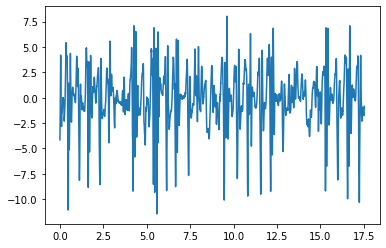

In [40]:
plt.plot(t,x_acc)

In [41]:
fig = go.Figure()
fig.add_scatter(x = t, y = x_acc, mode='lines', name='Sum squares')

#fig.for_each_trace(
#    lambda trace: trace.update(name=trace.name.replace("_value", "")),
#)

#fig.layout.template = 'plotly_white'

fig.show()

In [48]:
track, basis = phase_track(x_acc.reshape([-1,1]), 200, 3)

Explained variation for 3 principal components: [0.15524846 0.15418971 0.1047594 ]
Cumulative explained variationfor 3 principal components: 0.4141975709518637



In [49]:
plot_phase_track(track)